## Bollinguer Bands algo

1. Obtain candlestick data for a specific crypto.
2. The function would be passing a single crypto (or maybe an array?)
3. Perform algorithmic operations 
    - Price is passing top band 2 or 3 times (buy position)
    - Price is going below bottom band 2 or 3 times (sell position)

In [1]:
# libraries
import urllib.request as r
import json
import pandas as pd
import numpy as np
import matplotlib as plt
# candlestick
from mpl_finance import candlestick2_ochl
from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [16]:
# Get data for a single crypto e.g. BTT in BNB market
base = 'https://api.binance.com'
ticker24 = '/api/v1/ticker/24hr'
candlestick = '/api/v1/klines'
params = '?symbol=ETCETH&interval=15m'
# for Bollinger bands 20 day
bb_params = '?symbol=BTTBNB&interval=12h'
httpRes = r.urlopen(base + candlestick + params)
data = json.load(httpRes)

In [17]:
columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades','Taker buy base asset volume','Taker buy quote asset volume','ignore']
df = pd.DataFrame(data, columns=columns)
original_data = df;

## Function to parse data coming in

This only works if we are working with the same Json data.
This works if format matched 100%

In [18]:
# change default precision of decimals
pd.set_option("display.precision", 8)
# clean and parse data
dateFormat = '%d/%m/%Y'
# df.drop('ignore', axis=1, inplace=True)
df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')
df[['Open', 'High', 'Low', 'Close', 'Taker buy quote asset volume']] = df[['Open', 'High', 'Low', 'Close', 'Taker buy quote asset volume']].apply(lambda x: x.astype(float))
df[['Volume', 'Taker buy base asset volume']] = df[['Volume', 'Taker buy base asset volume']].apply(lambda x: x.astype(float))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
Open time                       500 non-null datetime64[ns]
Open                            500 non-null float64
High                            500 non-null float64
Low                             500 non-null float64
Close                           500 non-null float64
Volume                          500 non-null float64
Close time                      500 non-null datetime64[ns]
Quote asset volume              500 non-null object
Number of trades                500 non-null int64
Taker buy base asset volume     500 non-null float64
Taker buy quote asset volume    500 non-null float64
ignore                          500 non-null object
dtypes: datetime64[ns](2), float64(7), int64(1), object(2)
memory usage: 47.0+ KB


## Plotting candlestick

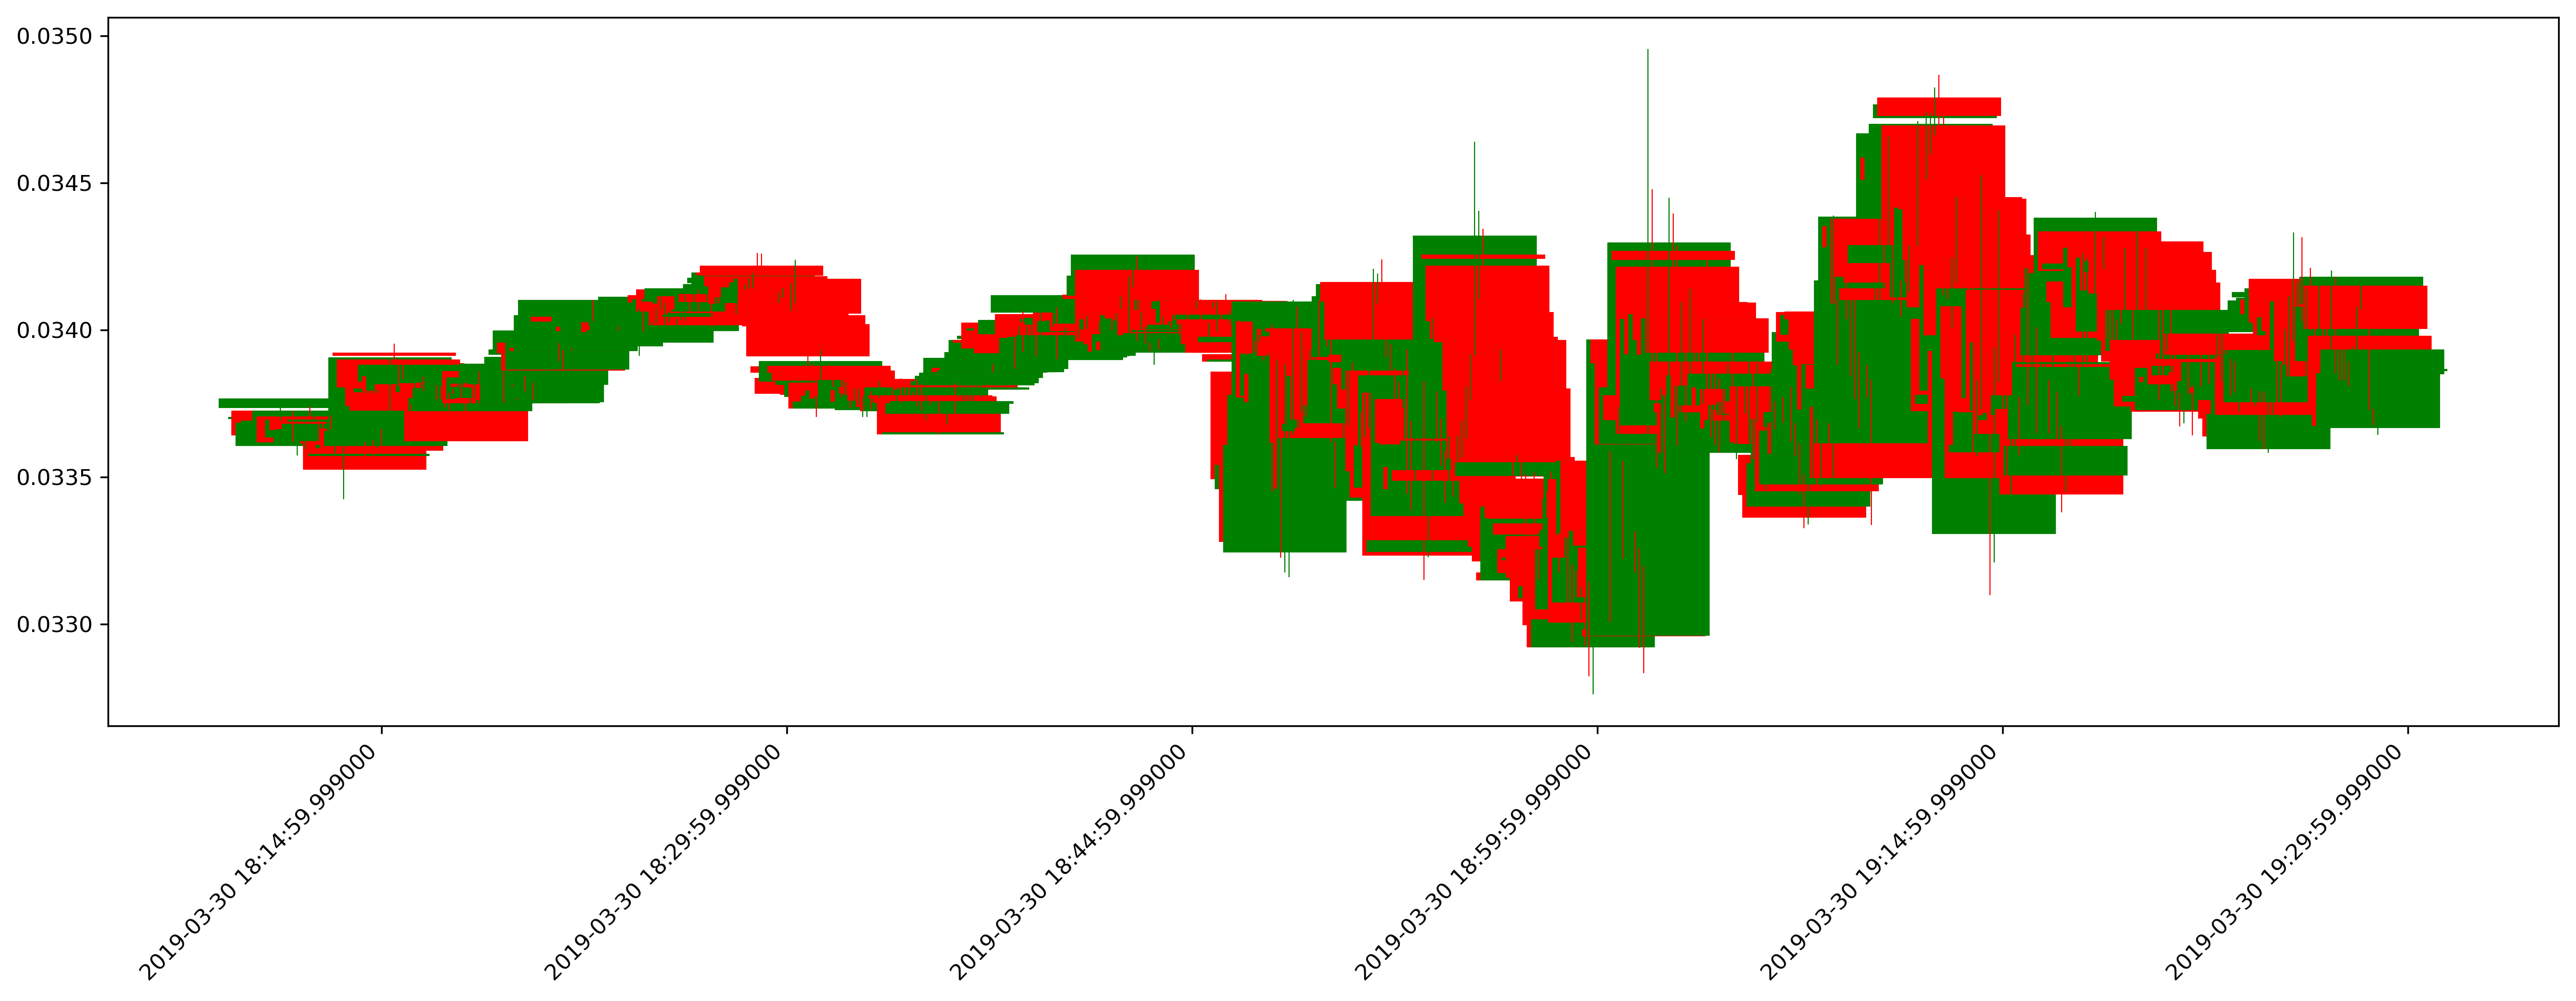

In [19]:
ohlc_df = df[['Open time', 'Open', 'High', 'Low', 'Close', 'Close time', 'Volume']]
quotes = zip(ohlc_df['Close time'].apply(mdates.date2num), ohlc_df['Open'], ohlc_df['High'], ohlc_df['Low'], ohlc_df['Close'])
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = plt.subplot2grid((10, 5), (1, 0), rowspan=6, colspan=8)
candlestick_ohlc(ax, quotes, width=0.3, colorup='g')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
ax.set_xticklabels(ohlc_df['Close time'],rotation=45, horizontalalignment='right')
plt.show()

## Bollinguer bands + EWMA

In [22]:
# adding data
pd.options.mode.chained_assignment = None
ohlc_df['MA-30'] = pd.Series(ohlc_df['Close'].rolling(window=20).mean(), index=ohlc_df.index)
ohlc_df['Upper'] = pd.Series(ohlc_df['MA-30'] + 2*ohlc_df['Close'].rolling(window=20).std(), index=ohlc_df.index)
ohlc_df['Lower'] = pd.Series(ohlc_df['MA-30'] - 2*ohlc_df['Close'].rolling(window=20).std(), index=ohlc_df.index)

# signal line for MACD
ohlc_df['EWMA6'] = pd.Series(ohlc_df['Close'].ewm(span=6).mean(),  index=ohlc_df.index)
# Add Exponential Weighted MA
ohlc_df['EWMA12'] = pd.Series(ohlc_df['Close'].ewm(span=12).mean(),  index=ohlc_df.index)
ohlc_df['EWMA26'] = pd.Series(ohlc_df['Close'].ewm(span=26).mean(),  index=ohlc_df.index)
ohlc_df['MACD']= pd.Series(ohlc_df['EWMA26'] - ohlc_df['EWMA12'])
ohlc_df.dropna(inplace=True)
ohlc_df.tail()

,Open time,Open,High,Low,Close,Close time,Volume,MA-30,Upper,Lower,EWMA6,EWMA12,EWMA26,MACD
495,2019-04-04 21:30:00,0.033976,0.034035,0.033728,0.033728,2019-04-04 21:44:59.999,163.28,0.03399735,0.03423495,0.03375975,0.03392840,0.03394653,0.03394284,-0.00000369
496,2019-04-04 21:45:00,0.033725,0.033730,0.033677,0.033677,2019-04-04 21:59:59.999,79.27,0.03397640,0.03424873,0.03370407,0.03385657,0.03390506,0.03392315,0.00001809
497,2019-04-04 22:00:00,0.033669,0.033849,0.033644,0.033849,2019-04-04 22:14:59.999,458.38,0.03396260,0.03423117,0.03369403,0.03385441,0.03389644,0.03391766,0.00002122
498,2019-04-04 22:15:00,0.033853,0.033930,0.033853,0.033930,2019-04-04 22:29:59.999,20.29,0.03395385,0.03421416,0.03369354,0.03387600,0.03390160,0.03391857,0.00001697
499,2019-04-04 22:30:00,0.033863,0.033863,0.033863,0.033863,2019-04-04 22:44:59.999,4.17,0.03394420,0.03420287,0.03368553,0.03387229,0.03389566,0.03391446,0.00001879


### Plotting both candlestick and Bollinger

[Text(737148.0, 0, '2019-03-30 22:29:59.999000'),
 Text(737149.0, 0, '2019-03-30 22:44:59.999000'),
 Text(737150.0, 0, '2019-03-30 22:59:59.999000'),
 Text(737151.0, 0, '2019-03-30 23:14:59.999000'),
 Text(737152.0, 0, '2019-03-30 23:29:59.999000'),
 Text(737153.0, 0, '2019-03-30 23:44:59.999000'),
 Text(737154.0, 0, '2019-03-30 23:59:59.999000'),
 Text(737155.0, 0, '2019-03-31 00:14:59.999000')]

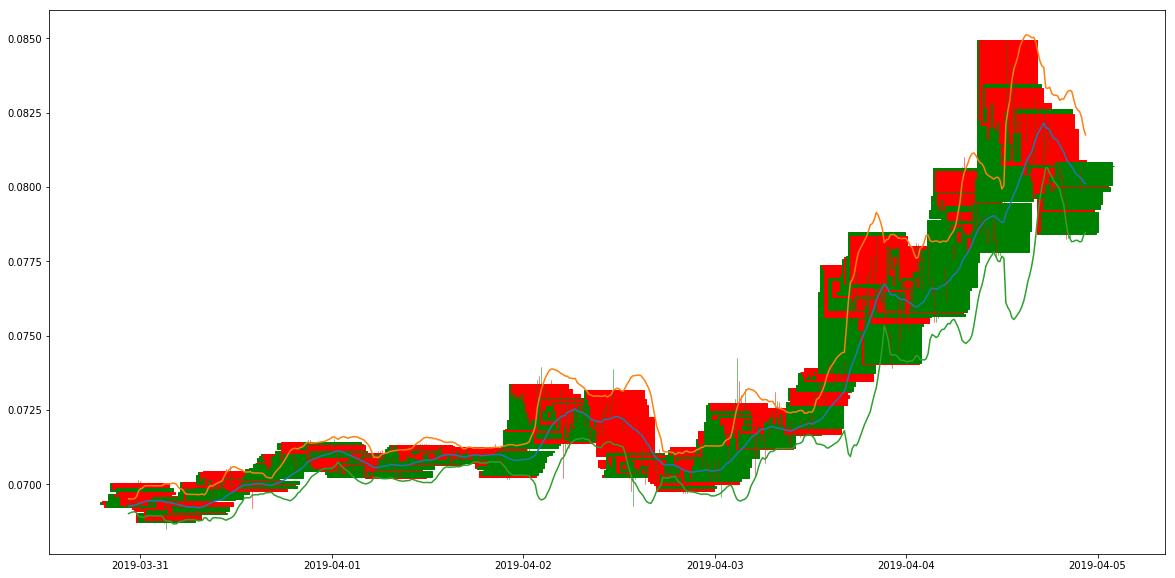

In [12]:
# plot config
# ohlc_df.head()
quotes = zip(ohlc_df['Close time'].apply(mdates.date2num), ohlc_df['Open'], ohlc_df['High'], ohlc_df['Low'], ohlc_df['Close'])
# Bollinguer
# fig = plt.figure(figsize=(20, 10), dpi=300)
# ax = plt.subplot2grid((10, 5), (1, 0), rowspan=6, colspan=8)
fig, ax1 = plt.subplots(figsize=(20,10))
candlestick_ohlc(ax1, quotes, width=0.3, colorup='g')
plt.plot(ohlc_df['Close time'], ohlc_df['MA-30'])
plt.plot(ohlc_df['Close time'], ohlc_df['Upper'])
plt.plot(ohlc_df['Close time'], ohlc_df['Lower'])
plt.plot(xlim=['2019-04-04', '2019-04-05'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
ax.set_xticklabels(ohlc_df['Close time'],rotation=45, horizontalalignment='right')

# plt.show()

### Fixing width to analyze certain parts of the plot

Use the line `plt.xlim` to fix dates for zoom in viewing

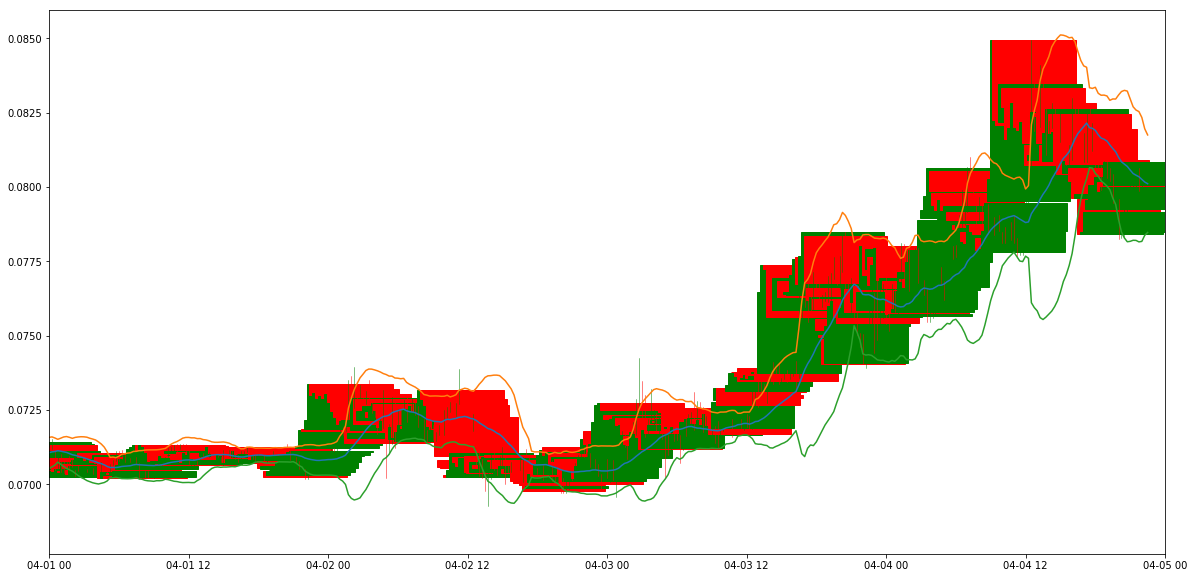

In [15]:
# plot config
# ohlc_df.head()
quotes = zip(ohlc_df['Close time'].apply(mdates.date2num), ohlc_df['Open'], ohlc_df['High'], ohlc_df['Low'], ohlc_df['Close'])
# Bollinguer
# fig = plt.figure(figsize=(20, 10), dpi=300)
# ax = plt.subplot2grid((10, 5), (1, 0), rowspan=6, colspan=8
fig, ax1 = plt.subplots(figsize=(20,10))
candlestick_ohlc(ax1, quotes, width=0.3, colorup='g')
plt.plot(ohlc_df['Close time'], ohlc_df['MA-30'])
plt.plot(ohlc_df['Close time'], ohlc_df['Upper'])
plt.plot(ohlc_df['Close time'], ohlc_df['Lower'])
# ohlc_df['Close time']
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
ax.set_xticklabels(ohlc_df['Close time'],rotation=45, horizontalalignment='right')

# set width here
plt.xlim('2019-04-01', '2019-04-05')
plt.show()